## Inference for Demo
**Data preprocessing**: Resize to 224x224 and apply n=2 morphological thinning

**Model**: Yu classify all

In [ ]:
# !pip install pickle5

In [1]:
# import libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, losses, optimizers, regularizers, callbacks

import os
import time
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

import cv2
from scipy.ndimage import median_filter
from skimage.transform import resize as sk_resize
from skimage.util import img_as_ubyte
from skimage.morphology import skeletonize, thin

import helpers as helper
from keras_model_s3_wrapper import *

import boto3
import pickle5 as pickle
s3 = boto3.resource('s3')
bucket_name = 'wafer-capstone'
my_bucket = s3.Bucket(bucket_name)

In [2]:
tf.__version__

'2.3.4'

In [3]:
tf.config.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Load the data
Dataset must have the following columns: 
- **waferMap**: defect data of wafer map where 0 = blank spot, 1 = normal die (passed the electrical test), and 2 = broken die (failed electrical test); data type must be np.uint8
- **ID**: unique identification for each waferMap, separate from dataframe index

In [4]:
# specify variables

# specify data to load
path = 'processed_data/customer' # S3 folder where data lives
filename = 'WM-unlabeled-demo424' # data filename in S3

# where to save results
result_path = '../results' # folder in local instance to save results
result_filename = 'demo_results' # filename to save the results as

# which model to run
model = 'yuclassify-224thin2-all-rotflip'

In [5]:
# load data directly from S3 (using boto3 resource)
start = time.time()

data_key = f'{path}/{filename}.pkl'
data = pickle.loads(my_bucket.Object(data_key).get()['Body'].read())

print("Wall time: {:.2f} seconds".format(time.time() - start))
print(f"Dataset length: {len(data)}")

Wall time: 0.29 seconds
Dataset length: 5000


### Data preprocessing

In [6]:
# resize to 224x224 --> binarize --> apply n=2 morphological thinning
start = time.time()

def preprocess(x):
    y = sk_resize(x, [224,224])
    new_y = img_as_ubyte(y)
    ret, thresh_img = cv2.threshold(new_y, 1, 1, cv2.THRESH_BINARY)
    thin_img = thin(thresh_img, 2)
    return thin_img
    
data['thinMap2'] = data.waferMap.apply(lambda x: preprocess(x))
data['thinMap2'] = data.thinMap2.apply(lambda x: x.astype(np.uint8))

print("Wall time: {:.2f} seconds".format(time.time() - start))
print("Sanity checks:")
print(f'Map shape: {data.thinMap2[0].shape}')
print(f'Map unique values:{np.unique(data.thinMap2[0])}')

Wall time: 31.37 seconds
Sanity checks:
Map shape: (224, 224)
Map unique values:[0 1]


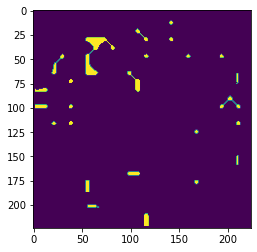

In [7]:
plt.imshow(data.thinMap2[0])

### GoogLeNet Model

##### Data set-up

In [8]:
# prepare inputs
start = time.time()

x_cls = np.stack(data['thinMap2'])
x_cls = tf.expand_dims(x_cls, axis=3, name=None)

print("Wall time: {:.2f} seconds".format(time.time() - start))
# sanity check
# expected: TensorShape([#rows, xdim, ydim, 1])
x_cls.shape

Wall time: 16.20 seconds


TensorShape([5000, 224, 224, 1])

##### Load and run model

In [9]:
# load saved classify model from S3
start = time.time()

classify = s3_get_keras_model(model)
classify.summary()

print("Wall time: {:.2f} seconds".format(time.time() - start))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 224, 224, 1)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 224, 224, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 74, 74, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 74, 74, 64)        3

In [10]:
# generate predictions
start = time.time()

classify_pred = classify.predict(x_cls)
cls_labels = np.argmax(classify_pred, axis=1).astype(np.uint8)

print("Wall time: {:.2f} seconds".format(time.time() - start))

Wall time: 34.51 seconds


In [11]:
# save predictions to local instance
predictions = [classify_pred, cls_labels]
with open(f'{result_path}/{result_filename}.pkl', "wb") as f:
    pickle.dump(predictions, f)